In [9]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.8 MB 8.5 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.8 MB 9.2 MB/s eta 0:00:01
   -------------------------------- ------- 6.3/7.8 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 12.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 29.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [89]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Step 1: Vizualize the data


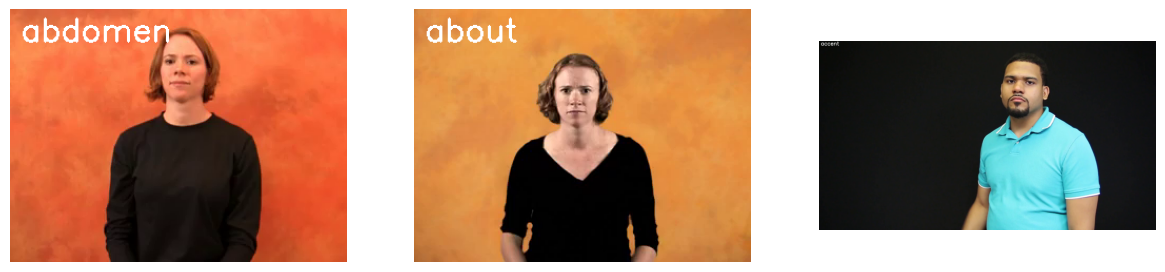

In [96]:
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize = (20, 20))

# Get the names of the classses
all_class_names = os.listdir('Preprocessing')

# Iterate through all labels
for index in range(3):
    # Retrieve a class name using the index
    selected_class_name = all_class_names[index]

    # Retrieve the list of all video files present in the class directory
    video_file_names_list = os.listdir(f'Preprocessing/{selected_class_name}')

    # Select a video file from the class directory
    selected_video_file_name = video_file_names_list[0]

    # Init a VideoCapture object to read from the video file
    video_reader = cv2.VideoCapture(f'Preprocessing/{selected_class_name}/{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # Releases the VideoCapture object
    video_reader.release()

    # Convert the frame from BGR to RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    plt.subplot(5, 4, index + 1)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Step 2: Preprocess the Dataset

In [91]:
# Specify the height and width to which each video frame will be resized to in our dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128

# Specify the number of frames of a video that will be fed to the model as one sequence
# Videos are 25fps and 1-2 second each
# Each video is 25-50 frames total
# So we will only feed 20 frames of the original videos to the model 
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset
DATASET_DIR = "Preprocessing"

# Specify the list containing the names of the classes used for training. Only using 3 for now
CLASS_LIST = ["abdomen", "about", "accent"]

### Create a function to Extract, Resize, and Normaize Frames

In [92]:
def frames_extraction(video_path):
    # Declare a list to store the video frames that will be extracted
    frames_list = []

    # Create a VideoCapture object to read the video file
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the number of frames to skip between each extracted frame
    # This ensures that SEQUENCE_LENGTH frames are extracted evenly throughout the video
    skip_frame_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Loop through the desired number of frames (SEQUENCE_LENGTH)
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the position of the next frame to be read, skipping frames evenly
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_window)

        # Read the frame from the video at the current position
        success, frame = video_reader.read()

        # If reading the frame fails (e.g., video ends early), exit the loop
        if not success:
            break

        # Resize the frame to a specific height and width (IMAGE_HEIGHT and IMAGE_WIDTH)
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the pixel values by dividing by 255 to scale them between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame to the list of frames
        frames_list.append(normalized_frame)

    # Release the video capture object to free up resources
    video_reader.release()

    # Return the list of extracted and normalized frames
    return frames_list


### Create a Function for Dataset Creation

In [93]:
def create_dataset():
    # Initialize empty lists to store the features (frames), labels (class indices), and video file paths
    features = []
    labels = []
    video_file_paths = []

    # Iterate over the list of classes using enumerate, which gives both the index and class name
    for class_index, class_name in enumerate(CLASS_LIST):
        # Print the current class being processed to keep track of progress
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of all files in the current class directory
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate over all the video files in the current class
        for file_name in files_list:
            # Construct the full path to the video file
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract frames from the video file using the frames_extraction function
            frames = frames_extraction(video_file_path)

            # Append the extracted frames (features) to the features list
            features.append(frames)
            
            # Append the class index (label) to the labels list to associate the frames with their class
            labels.append(class_index)

            # Append the video file path for reference or debugging
            video_file_paths.append(video_file_path)

    # Convert the features and label lists to a NumPy array 
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the extracted features, labels, and video file paths
    return features, labels, video_file_paths


In [94]:
# Create the dataset
features, labels, video_file_paths = create_dataset()

Extracting Data of Class: abdomen
Extracting Data of Class: about
Extracting Data of Class: accent


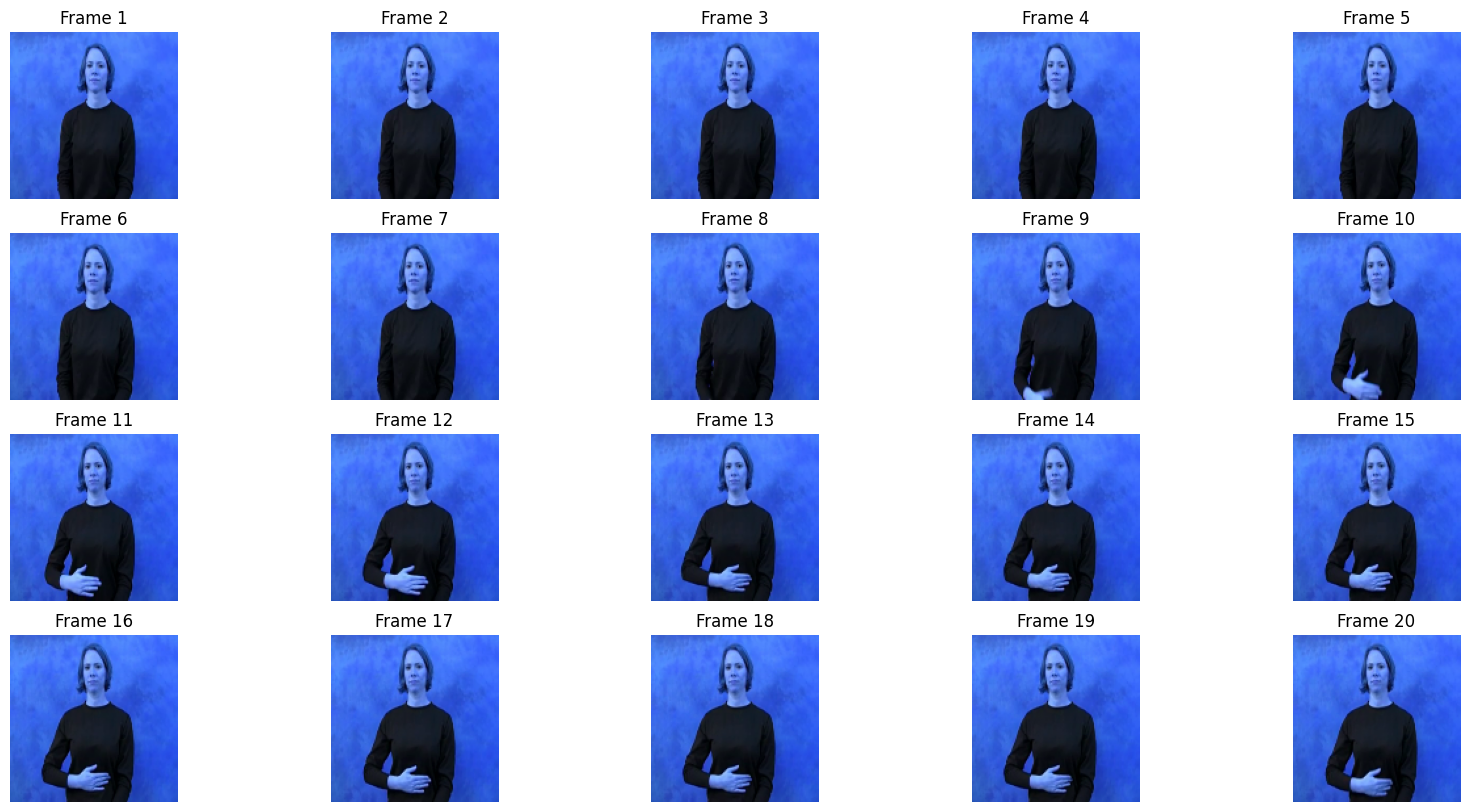

In [95]:
# Visualize a sequence of 20 frames from the first video
plt.figure(figsize=(20, 10))

# Ensure we don't exceed the available frames
sequence_length = min(20, len(features[0]))

for i in range(sequence_length):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns for 20 frames
    plt.imshow(features[0][i])  # First video, ith frame
    plt.title(f'Frame {i + 1}')
    plt.axis('off')

plt.show()
